<a href="https://colab.research.google.com/github/aldencabajar/kaggle-m5-comp-scripts/blob/master/m5_nn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import gc
calendar = pd.read_csv("drive/My Drive/calendar.csv")
sales = pd.read_csv("drive/My Drive/sales_train_evaluation.csv")
print("calendar shape:" , calendar.shape, "\nsales shape:", sales.shape)

calendar shape: (1969, 14) 
sales shape: (30490, 1947)


In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [7]:
reduce_mem_usage(calendar)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%


In [8]:
from tqdm import tqdm
days_col = sales.columns[sales.columns.str.contains(r'd_\d*')] 
def ts_agg(df, grp, i):
    if 'X' in grp and 'Total' not in grp:
        agg_col = grp[np.where(np.array(grp) != 'X')[0][0]]
        fn = df[np.append(agg_col, days_col)].set_index(agg_col).groupby(agg_col).apply(sum).reset_index()
        fn['id2'] = 'X'
        fn['id'] = fn[np.array([agg_col, 'id2'])].apply(lambda x: '_'.join(x), axis = 1).values
        #fn.drop([agg_col, 'id2'], inplace = True, axis = 1)
        
    elif 'Total' in grp:
        df['id'] = 'Total_X'
        fn = df[np.append('id', days_col)].set_index('id').groupby('id').apply(sum).reset_index()
        
        
    else:
        fn = df[np.append(grp, days_col)].set_index(grp).groupby(grp).apply(sum).reset_index()
        fn['id'] = fn[grp].apply(lambda x: '_'.join(x), axis = 1).values
        #fn.drop(grp, inplace = True, axis = 1)
    
    fn['lvl'] = i 
        
    return(fn)
### DETERMINE AGGREGATED SALES ####
levels = (['Total','X'], ['state_id', 'X'], ['store_id', 'X'], ['cat_id', 'X'], ['dept_id', 'X'], 
          ['state_id', 'cat_id'], ['state_id', 'dept_id'], ['store_id', 'cat_id'], ['store_id', 'dept_id'], 
          ['item_id', 'X'], ['state_id', 'item_id'], ['item_id', 'store_id'])

agg_sales_list = []
for i, lv in tqdm(enumerate(levels)):
    agg_sales_list.append(ts_agg(sales, lv, i + 1))



0it [00:00, ?it/s]
1it [00:00,  1.58it/s]
2it [00:01,  1.72it/s]
3it [00:01,  1.83it/s]
4it [00:02,  1.92it/s]
5it [00:02,  1.99it/s]
6it [00:02,  2.04it/s]
7it [00:03,  2.07it/s]
8it [00:03,  2.08it/s]
9it [00:04,  2.06it/s]
10it [00:07,  1.35s/it]
11it [00:12,  2.42s/it]
12it [00:26,  2.23s/it]


In [9]:
agg_sales_all = pd.concat(agg_sales_list)
agg_sales_all.reset_index(drop = True, inplace = True)
agg_sales_all.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,...,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,lvl,state_id,id2,store_id,cat_id,dept_id,item_id
0,Total_X,32631,31749,23783,25412,19146,29211,28010,37932,32736,25572,23071,23658,23756,26445,34833,36380,21804,24070,21443,20318,23721,31689,29283,23966,20501,20757,20277,22529,29908,28707,21240,22872,22046,23475,23572,31202,34876,24562,22752,...,35343,35033,40517,48962,49795,38793,35487,34445,34732,42896,50429,53032,43181,44314,39601,40763,43805,54239,45609,46400,39379,42248,40503,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338,1,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_X,14195,13805,10108,11047,9925,11322,12251,16610,14696,11822,10933,10350,11204,11354,14610,15630,9044,9496,8844,7835,10025,13870,13465,11997,9130,8941,8514,9847,13652,12491,9196,9782,9537,9710,10444,13784,16057,10953,10299,...,15148,14488,17095,21834,23187,17524,15012,14836,14664,17180,22327,23689,19117,17830,17266,16197,17638,23119,19960,18916,16971,16191,15498,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644,2,CA,X,NaN,NaN,NaN,NaN
2,TX_X,9438,9630,6778,7381,5912,9006,6226,9440,9376,7319,6224,6740,6109,7202,10081,11725,6719,7460,6606,6412,6711,9150,9789,7297,6628,5814,6175,6286,8586,9086,6555,7082,6145,6639,6584,9238,10423,7623,6335,...,9600,9602,10615,12266,12282,10662,9933,9575,9655,12162,12694,14193,10719,11949,9909,10833,11773,13668,11385,12035,10580,11314,11491,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815,2,TX,X,NaN,NaN,NaN,NaN
3,WI_X,8998,8314,6897,6984,3309,8883,9533,11882,8664,6431,5914,6568,6443,7889,10142,9025,6041,7114,5993,6071,6985,8669,6029,4672,4743,6002,5588,6396,7670,7130,5489,6008,6364,7126,6544,8180,8396,5986,6118,...,10595,10943,12807,14862,14326,10607,10542,10034,10413,13554,15408,15150,13345,14535,12426,13733,14394,17452,14264,15449,11828,14743,13514,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879,2,WI,X,NaN,NaN,NaN,NaN
4,CA_1_X,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078,4316,4354,2757,2430,2272,2009,3015,4553,3966,3264,2441,2377,2414,2701,3719,3548,2246,2549,2559,2568,2978,4096,4832,3138,2997,...,3722,3709,4387,5577,6113,4472,3703,3715,3618,4573,5898,6397,4794,4594,4234,3918,4804,6069,5212,4859,4104,3982,4049,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289,3,NaN,X,CA_1,NaN,NaN,NaN


In [10]:
agg_sales_all['wt'] = agg_sales_all.loc[:,days_col] \
.apply(lambda x: np.abs(x- x.shift(1)).mean(), axis = 1)
agg_sales_all['wt']

0        4278.666495
1        1969.115979
2        1348.466495
3        1439.687113
4         651.286598
            ...     
42835       0.388144
42836       0.197938
42837       0.152577
42838       0.064948
42839       0.226804
Name: wt, Length: 42840, dtype: float64

Add dummy sales columns (from day 1942 to 1969) to facilitate creation of evaluation days features 

In [11]:
d_cols_eval = ['d_' + str(i) for i in range(1942, 1970)] 
for d in d_cols_eval:
  agg_sales_all[d] = np.nan 

In [12]:
from datetime import datetime
import gc
def create_dataset(start_day, lags):
  days_col = agg_sales_all.columns[
  agg_sales_all.columns.str.contains(r'd_\d*')]

  # determine the minimum day when sales was non-zero  
  agg_sales_all['min_day_sales'] = agg_sales_all.loc[:,days_col] \
  .apply(lambda x: np.min(np.where(x > 0)[0] + 1), axis = 1)

  print("melting the dataset...")
  agg_melt = pd.melt(agg_sales_all.loc[:,list(days_col) + ['id', 'min_day_sales', 'wt']], 
                   var_name = "day", value_name = "sales", 
                   id_vars = ['id', 'min_day_sales', 'wt'])

  start_mem = agg_melt.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
  agg_melt['day'] = agg_melt['day'].str.replace('d_', '').astype(np.int16)
  agg_melt['min_day_sales'] = agg_melt['min_day_sales'].astype(np.int16)
  agg_melt['sales'] = agg_melt['sales'].astype(np.float32)
  agg_melt['wt'] = agg_melt['wt'].astype(np.float32)
  end_mem = agg_melt.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(end_mem))

  agg_melt.sort_values(by = ["id", "day"], inplace = True)
  agg_melt.reset_index(inplace = True, drop = True)

  print( 'maximum weight:', np.nanmax(agg_melt['wt']), '\nminimum weight:', 
        np.nanmin(agg_melt['wt']))

  agg_melt = agg_melt.loc[
    (agg_melt.min_day_sales <= agg_melt.day) & (agg_melt.day >= start_day)]
  
  agg_melt['scaled'] = agg_melt['sales'] / agg_melt['wt']
  
  # create lagged variables
  print('creating lagged variables...')
  if np.any(np.array(lags) < 28):
    return(print("please pick a lagged variable greater than 28 days")) 
  else:
    for lag in lags:
      lag_name = "lag" + str(lag)
      agg_melt[lag_name] = agg_melt.groupby("id")['scaled'].shift(lag)
    # drop lagged variables with null values 
    lag_vars = agg_melt.columns[agg_melt.columns.str.contains('lag')]
    agg_melt = agg_melt.dropna(subset = lag_vars)

  # remmove unnecessary vars
  print('removing unnecessary variables...')
  agg_melt.drop(columns = ['min_day_sales'], inplace = True)
  gc.collect()


  # prepare calendar variables
  print('preparing calendar variables...')
  calendar = pd.read_csv("drive/My Drive/calendar.csv")
  reduce_mem_usage(calendar)
  calendar['date1'] = calendar.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
  calendar['start_date_year'] = calendar.year.apply(lambda x: datetime.strptime(str(x) + '-01-01', '%Y-%m-%d'))
  calendar['day_of_year'] = calendar['date1'] - calendar['start_date_year']
  calendar['day_of_year'] = calendar['day_of_year'].apply(lambda x: x.days + 1).astype(np.int16)
  calendar['d'] = calendar['d'].str.replace("d_", "").astype(np.int16)
  var_list = ['wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'day_of_year']

  # convert events to integers, can be thought of as ordinal encoding, although
  # this might not be a good way to represent it 
  event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
  calendar[event_cols] = calendar[event_cols].apply(lambda x: x.astype("category").cat.codes)

  print('merging with sales...')
  sales_calendar_merge = pd.merge(calendar[var_list], 
                                  agg_melt, right_on = "day", 
                                  left_on = "d", how = "right") \
                                  .sort_values(by =['id', 'day'], ignore_index  = True)
  sales_calendar_merge.drop(columns = ['d'], inplace=True)                                
  del agg_melt; gc.collect()
  print('dataset shape:', sales_calendar_merge.shape)


  return(sales_calendar_merge)



In [13]:
dataset = create_dataset(start_day=1000, lags=[28, 35, 42, 49, 56, 63])


melting the dataset...
Memory usage of dataframe is 3217.77 MB
Memory usage of dataframe is 1608.89 MB
maximum weight: 4278.6665 
minimum weight: 0.010309278
creating lagged variables...
removing unnecessary variables...
preparing calendar variables...
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%
merging with sales...
dataset shape: (37213892, 22)


Standardize values and make sure that other variables do not have very large ranges.

In [14]:
dataset['year'] -= 2011
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
day_of_year = np.arange(1, 366).reshape((-1, 1)) 
scaler.fit(day_of_year)
dataset['day_of_year_s'] = scaler.transform(dataset.day_of_year.values.reshape(-1, 1))


We now prepare the input data that we will be using for the train, test and validation

In [15]:
train_data = dataset[dataset.day <= 1913]
train_data = train_data[np.isfinite(train_data.wt)]
validation_data = dataset[np.logical_and(dataset.day <= 1941, dataset.day > 1913)]
evaluation_data = dataset[np.logical_and(dataset.day > 1941, dataset.day <= 1969)]



In [16]:
  print('train max day:', np.max(train_data['day']),
      '\nvalidation max day:', np.max(validation_data['day']),
      '\nevaluation max day:', np.max(evaluation_data['day']))



train max day: 1913 
validation max day: 1941 
evaluation max day: 1969


In [17]:
print('train data shape:', train_data.shape,
      '\nvalidation data shape:', validation_data.shape,
      '\nevaluation data shape:', evaluation_data.shape)


train data shape: (34814852, 23) 
validation data shape: (1199520, 23) 
evaluation data shape: (1199520, 23)


In [18]:
evaluation_data.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year,id,wt,day,sales,scaled,lag28,lag35,lag42,lag49,lag56,lag63,day_of_year_s
879,3,5,5,-1,-1,-1,-1,0,0,0,144,CA_1_FOODS,465.540192,1942,NaN,NaN,6.214286,6.199250,6.177770,7.030542,5.327145,5.941485,-0.370138
880,4,5,5,-1,-1,-1,-1,0,0,0,145,CA_1_FOODS,465.540192,1943,NaN,NaN,5.408771,5.344329,5.095156,5.823342,5.329293,5.580614,-0.360648
881,5,5,5,-1,-1,-1,-1,0,0,0,146,CA_1_FOODS,465.540192,1944,NaN,NaN,5.299220,5.348625,5.028567,5.795418,4.586070,5.486100,-0.351157
882,6,5,5,-1,-1,-1,-1,0,0,0,147,CA_1_FOODS,465.540192,1945,NaN,NaN,5.254111,5.440991,5.200410,5.262703,5.694460,5.758901,-0.341666
883,7,5,5,-1,-1,-1,-1,0,0,0,148,CA_1_FOODS,465.540192,1946,NaN,NaN,6.512864,6.358205,5.812603,6.747001,6.727668,7.348453,-0.332175


In [19]:
validation_data.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year,id,wt,day,sales,scaled,lag28,lag35,lag42,lag49,lag56,lag63,day_of_year_s
851,3,4,5,-1,-1,-1,-1,0,0,0,116,CA_1_FOODS,465.540192,1914,2893.0,6.214286,5.327145,5.941485,5.960817,6.394722,5.294924,5.297072,-0.635879
852,4,4,5,-1,-1,-1,-1,0,0,0,117,CA_1_FOODS,465.540192,1915,2518.0,5.408771,5.329293,5.580614,4.732137,5.773938,5.163894,5.168190,-0.626388
853,5,4,5,-1,-1,-1,-1,0,0,0,118,CA_1_FOODS,465.540192,1916,2467.0,5.299220,4.586070,5.486100,5.073676,5.355069,5.230483,4.459336,-0.616897
854,6,4,5,-1,-1,-1,-1,0,0,0,119,CA_1_FOODS,465.540192,1917,2446.0,5.254111,5.694460,5.758901,4.749321,5.393734,5.294924,4.674140,-0.607406
855,7,4,5,-1,-1,-1,-1,0,0,0,120,CA_1_FOODS,465.540192,1918,3032.0,6.512864,6.727668,7.348453,5.904968,6.089700,6.089700,5.827639,-0.597916


prepare one-hot encoding indices for `id` values:  

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

def one_hot_fn(id_arr, ret_vocab = False):
  unique_ids = id_arr.unique()
  len_unique_ids = id_arr.value_counts().set_axis(unique_ids).values 
  stri_split = tf.strings.split(unique_ids, sep = "_")
  vocab, idx = tf.unique(stri_split.flat_values)
  encoded_ids = [one_hot(d, tf.size(vocab).numpy()) for d in unique_ids]
  max_length = np.max([len(i) for i in encoded_ids])
  padded_encoded = np.array(pad_sequences(encoded_ids, maxlen=max_length, padding='post'))
  padded_encoded = np.repeat(padded_encoded, len_unique_ids, axis = 0)

  if ret_vocab:
    return padded_encoded, vocab 
  else:
    return padded_encoded

train_id_enc, vocab = one_hot_fn(train_data['id'], ret_vocab = True)
validation_id_enc = one_hot_fn(validation_data['id'])
eval_id_enc = one_hot_fn(evaluation_data['id'])
print(train_id_enc.shape, validation_id_enc.shape, eval_id_enc.shape)

(34814852, 5) (1199520, 5) (1199520, 5)


### Setting up neural network architecture

For this model, let us try a multi-layer perceptron with *n* hidden layers as a baseline. This is unique since we also try to incorporate an embedding layer (to represent the different ids as a dense vector) along the modelling process. 

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return keras.backend.mean(v)


feat_vars = dataset.columns[~dataset.columns.isin(
    ['id', 'sales', 'scaled', 'wt', 'day_of_year', 'day'])]

def create_model(n_hidden_layers, hidden_units, lr):
  
  ts_id_input = layers.Input(shape = (None, ), dtype = 'int32', 
                             name =  "ts_id_input") 
  # represent vocabulary with a 16-d vector                           
  embedding = layers.Embedding(836, 100) 
  encoded_input = embedding(ts_id_input)

  # since there are ids with multiple words, average vectors into single 
  # representation of the phrase
  pooled_input = layers.GlobalAveragePooling1D()(encoded_input)
  num_input = layers.Input(shape = (feat_vars.shape[0],) , dtype = 'float32', 
                              name = 'ts_features')
  concat_layer = layers.concatenate([pooled_input, num_input])

  # involve dropout layer for regularization 
  for i in range(n_hidden_layers):
    if i < (n_hidden_layers - 1) :
      if i == 0:
        mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                          activation = 'relu')(concat_layer)
      else:
        mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                          activation = 'relu')(mod)
      mod = layers.Dropout(0.3)(mod)
      mod = layers.Concatenate(name = "ft"+str(i))([pooled_input, mod])

    elif i == (n_hidden_layers - 1):
      mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                         activation = 'relu')(mod)
  # output final dense layer with 9 outputs equal to the number of quantiles to 
  # be predicted                        
  preds = layers.Dense(9, activation="linear", name="preds")(mod)
  model = keras.Model(inputs = [ts_id_input, num_input], 
                      outputs = [preds])
  optim = keras.optimizers.Adam(learning_rate = lr)                   
  model.compile(loss=qloss, optimizer=optim)
  return(model)

In [22]:
model = create_model(n_hidden_layers = 3, hidden_units = 500, lr = 0.001)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ts_id_input (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    83600       ts_id_input[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 100)          0           embedding[0][0]                  
__________________________________________________________________________________________________
ts_features (InputLayer)        [(None, 17)]         0                                            
______________________________________________________________________________________________

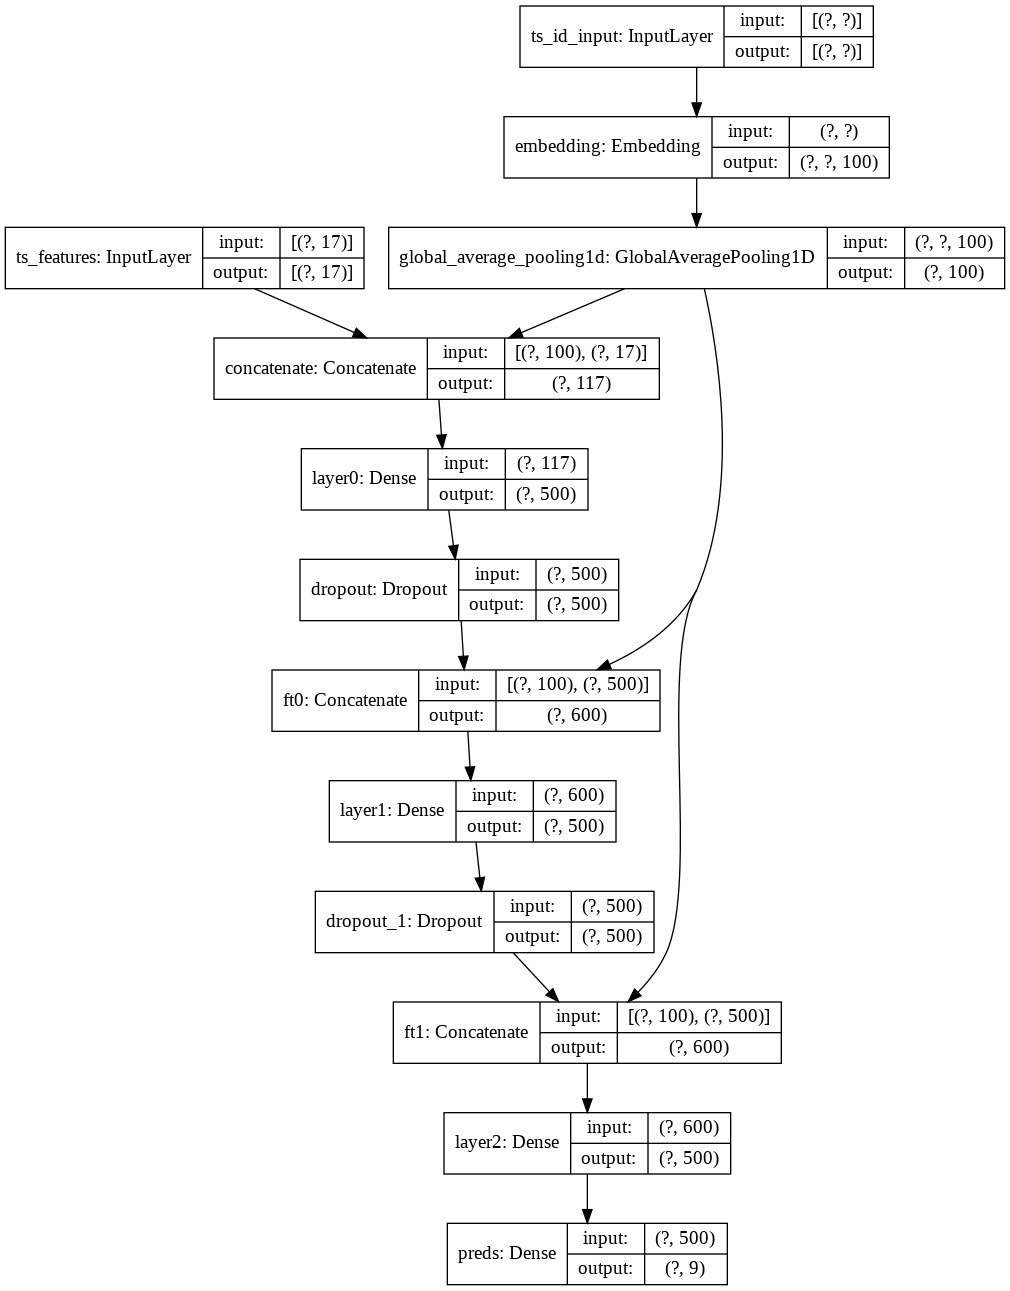

In [24]:
keras.utils.plot_model(model, show_shapes = True)

Defining a number of callbacks to further regulate neural network training  

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping 

ckpt = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)
es = EarlyStopping(monitor='val_loss', patience=5)

In [26]:
keras.backend.clear_session()
train_data_dict = {'ts_id_input': train_id_enc, 
                   'ts_features':train_data[feat_vars]}
val_data_dict = {'ts_id_input': validation_id_enc, 
                 'ts_features': validation_data[feat_vars]}
                 
history = model.fit(x = train_data_dict, y = train_data['scaled'].values, 
          validation_data = (val_data_dict, validation_data['scaled'].values), 
          batch_size = 100_000, epochs = 20, callbacks = [ckpt, reduce_lr, es])
          

Epoch 1/20
348/349 [============================>.] - ETA: 0s - loss: 0.2942
Epoch 00001: val_loss improved from inf to 0.36332, saving model to weights.h5
349/349 [==============================] - 58s 166ms/step - loss: 0.2942 - val_loss: 0.3633 - lr: 0.0010
Epoch 2/20
348/349 [============================>.] - ETA: 0s - loss: 0.2829
Epoch 00002: val_loss improved from 0.36332 to 0.35918, saving model to weights.h5
349/349 [==============================] - 57s 163ms/step - loss: 0.2829 - val_loss: 0.3592 - lr: 0.0010
Epoch 3/20
348/349 [============================>.] - ETA: 0s - loss: 0.2811
Epoch 00003: val_loss did not improve from 0.35918
349/349 [==============================] - 57s 162ms/step - loss: 0.2811 - val_loss: 0.3606 - lr: 0.0010
Epoch 4/20
348/349 [============================>.] - ETA: 0s - loss: 0.2799
Epoch 00004: val_loss improved from 0.35918 to 0.35886, saving model to weights.h5
349/349 [==============================] - 57s 162ms/step - loss: 0.2800 - val_lo

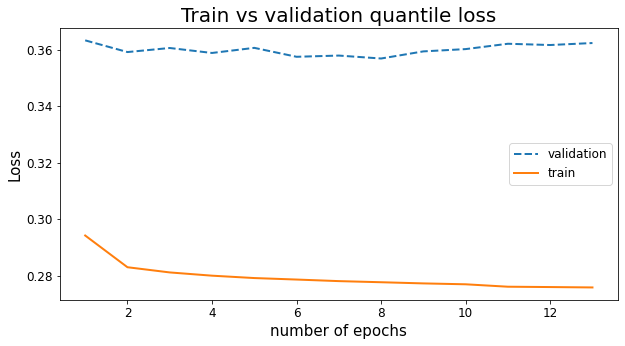

In [27]:
import matplotlib
import matplotlib.pyplot as plt
history_dict = history.history 
mean_q_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, figsize = (10, 5))
epochs = list(range(1, len(mean_q_loss) + 1))
ax.plot(epochs, validation_loss, linestyle = '--', linewidth = 2,
        label = "validation")
ax.plot(epochs, mean_q_loss, linewidth = 2, label = "train")
ax.set_xlabel('number of epochs', size = 15)
ax.set_ylabel('Loss', size = 15)
#ax.set_ylim([0, np.max(np.append(mean_q_loss, validation_loss))])
ax.legend()
plt.title('Train vs validation quantile loss', size = 20)
plt.show()


In [28]:
fnl = create_model(3, 500, lr = 0.0008)
fnl.load_weights("weights.h5")

In [29]:
eval_data_dict = {'ts_id_input': eval_id_enc, 
                   'ts_features':evaluation_data[feat_vars]}


val_preds = fnl.predict(val_data_dict, batch_size = 50_000) 
eval_preds = fnl.predict(eval_data_dict, batch_size = 50_000) 

print(val_preds.shape, eval_preds.shape)

(1199520, 9) (1199520, 9)


In [30]:
val_preds = val_preds.reshape((-1, 28, 9))
eval_preds = eval_preds.reshape((-1, 28, 9))

print(val_preds.shape, eval_preds.shape)

(42840, 28, 9) (42840, 28, 9)


In [31]:
val_preds

array([[[-2.62294412e-01,  4.11287546e-01,  4.63248205e+00, ...,
          6.25300503e+00,  7.75776625e+00,  9.44882965e+00],
        [-2.33587414e-01,  3.46296251e-01,  4.12021303e+00, ...,
          5.86900616e+00,  7.41043901e+00,  9.09314919e+00],
        [-2.18690097e-01,  3.57957244e-01,  3.97589326e+00, ...,
          5.63878155e+00,  7.06743860e+00,  8.65757847e+00],
        ...,
        [-2.88900793e-01,  4.92061675e-01,  5.40775537e+00, ...,
          6.85442972e+00,  8.26961994e+00,  9.91165447e+00],
        [-3.95033956e-01,  5.88709712e-01,  6.91307068e+00, ...,
          8.40934372e+00,  1.01299143e+01,  1.19893379e+01],
        [-4.08928007e-01,  5.99124968e-01,  7.19425488e+00, ...,
          8.64223385e+00,  1.03054781e+01,  1.21078806e+01]],

       [[-1.81508854e-01,  2.32505202e-01,  3.41165709e+00, ...,
          5.39050055e+00,  6.96674585e+00,  8.65423203e+00],
        [-1.74938411e-01,  5.50466925e-02,  2.52372098e+00, ...,
          5.08929014e+00,  7.11243773e

In [32]:
wts = evaluation_data[['wt', 'id']].drop_duplicates()
wts = wts.wt.values.reshape((-1, 1))
wts

array([[4.6554019e+02],
       [5.6371651e+01],
       [8.4910828e+01],
       ...,
       [2.2319588e-01],
       [3.9175257e-01],
       [1.4396871e+03]], dtype=float32)

In [33]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]

ids = validation_data['id'].unique()
d_cols =  ['F' + str(i) for i in range(1, 29)]

validation = []
evaluation = []

for i, qt in enumerate(QUANTILES):
  val_tmp = pd.DataFrame(val_preds[:, :, i] * wts, columns = d_cols)
  eval_tmp = pd.DataFrame(eval_preds[:, :, i] * wts, columns = d_cols)
  eval_tmp['id'] = ['_'.join([id, qt, 'evaluation']) for id in ids] 
  val_tmp['id'] = ['_'.join([id, qt, 'validation']) for id in ids] 
  validation.append(val_tmp)
  evaluation.append(eval_tmp)


validation_preds = pd.concat(validation).sort_values(by = 'id')
evaluation_preds = pd.concat(evaluation).sort_values(by = 'id')
submission = pd.concat([validation_preds, evaluation_preds])
submission.to_csv('submission.csv', index=False)



In [34]:
submission.head(25)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,id
0,-122.108589,-108.744331,-101.809029,-106.801849,-137.341171,-145.141876,-147.876511,-133.628418,-116.835114,-106.480759,-100.231598,-137.584869,-187.740219,-144.921066,-136.849823,-112.891365,-110.803696,-114.124153,-132.906372,-187.111481,-189.801651,-130.290131,-110.692474,-104.285179,-107.307327,-134.494934,-183.904190,-190.372421,CA_1_FOODS_0.005_validation
0,191.470886,161.214828,166.643478,164.577194,225.495880,244.386032,214.055573,184.898132,177.411911,171.590759,181.315125,227.394684,276.220703,228.150467,196.965759,180.675034,160.152740,189.443237,224.778900,280.001984,273.182556,190.995529,175.701508,165.514587,184.815826,229.074493,274.068024,278.916748,CA_1_FOODS_0.025_validation
0,2156.606689,1918.124756,1850.938110,1922.552490,2466.577637,2736.734375,2847.231689,2304.781982,2132.501465,2021.946899,2055.431885,2659.532227,3337.282471,2838.722656,2412.478516,2088.410889,1955.249878,2111.772461,2518.809082,3250.000732,3333.019287,2283.979736,1987.906372,1916.863647,2030.916748,2517.527588,3218.312256,3349.214844,CA_1_FOODS_0.165_validation
0,2236.681641,2008.472778,1939.685059,2016.033813,2540.464111,2858.699463,3015.071289,2411.750244,2216.407959,2118.393555,2159.322021,2740.322266,3408.782227,2984.884766,2498.552734,2175.069336,2038.289307,2183.721924,2587.434326,3308.148438,3400.043457,2367.614746,2074.899658,2006.524780,2111.329590,2583.859375,3272.135254,3404.260986,CA_1_FOODS_0.250_validation
0,2477.007568,2280.331299,2196.551514,2293.634521,2780.183838,3132.418213,3411.075439,2709.759521,2476.196777,2387.011230,2448.842041,2978.427979,3646.534668,3342.644531,2765.634766,2428.116699,2305.110352,2410.993652,2806.261230,3518.869873,3648.360596,2626.138428,2326.195068,2270.227295,2349.865967,2804.325684,3482.524170,3612.340820,CA_1_FOODS_0.500_validation
0,2763.703125,2574.890869,2469.176758,2576.862061,3033.624023,3446.609863,3772.849121,3049.940430,2783.575195,2670.748291,2705.236572,3258.196289,3978.283447,3658.671143,3094.768555,2708.079102,2613.977051,2688.897949,3060.100342,3838.992432,3977.590332,2936.246338,2609.777832,2556.091553,2606.939453,3046.429199,3787.812988,3899.638428,CA_1_FOODS_0.750_validation
0,2911.025146,2732.258301,2625.079346,2735.683350,3177.752686,3589.350098,3969.166504,3223.565918,2945.136475,2835.798828,2860.036133,3412.983887,4115.863770,3824.072998,3259.677002,2864.115234,2777.578369,2837.388428,3208.438477,3973.640381,4133.944824,3092.449463,2764.897705,2716.690674,2760.234131,3191.012451,3914.887451,4023.307129,CA_1_FOODS_0.835_validation
0,3611.552002,3449.857178,3290.176758,3440.156494,3846.995850,4421.884277,5049.386230,4079.783203,3683.207764,3557.660645,3538.829346,4168.707520,5003.889648,4788.590820,4068.770996,3564.895752,3503.533203,3505.994385,3866.539551,4802.920410,5033.439941,3873.534912,3474.740967,3427.744873,3418.408447,3849.840332,4715.882324,4797.614258,CA_1_FOODS_0.975_validation
0,4398.810059,4233.226562,4030.450684,4219.574219,4623.979004,5321.527344,6171.373047,5007.097656,4465.764648,4357.386230,4269.046875,5013.333496,5943.434570,5807.952148,4924.683594,4349.589844,4265.569824,4232.303711,4606.304688,5702.829102,5969.515137,4716.997559,4258.287109,4201.216309,4159.651855,4614.273438,5581.518555,5636.705078,CA_1_FOODS_0.995_validation
1,-10.231954,-9.861567,-8.796718,-10.710232,-13.801367,-15.291002,-12.580931,-10.545384,-10.243128,-8.607237,-9.526638,-12.978133,-19.894047,-11.740366,-10.657388,-9.818249,-9.001882,-10.701933,-12.477809,-18.450216,-14.161739,-10.142505,-9.366434,-9.033899,-10.061410,-12.420863,-18.313236,-13.734564,CA_1_FOODS_1_0.005_validation


In [35]:
submission.tail(25)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,id
42837,-0.001212,-0.001213,-0.001036,-0.001158,-0.000924,-0.001609,-0.001193,-0.000991,-0.001176,-0.001120,-0.001166,-0.001335,-0.000869,-0.001285,-0.001433,-0.001099,-0.001280,-0.001071,-0.001206,-0.001270,-0.001146,-0.005233,-0.001296,-0.001307,-0.001090,-0.001054,-0.001213,-0.000763,WI_HOUSEHOLD_2_515_0.165_evaluation
42837,-0.003119,-0.003250,-0.002775,-0.003472,-0.002925,0.001707,-0.003291,-0.003117,-0.003195,-0.003317,-0.003529,-0.002769,-0.003200,-0.003215,-0.003540,-0.003121,-0.003332,-0.003254,-0.003365,-0.003247,-0.003125,0.004359,-0.003325,-0.003004,-0.003030,-0.003025,-0.003279,-0.001612,WI_HOUSEHOLD_2_515_0.250_evaluation
42837,0.003363,0.003591,0.004088,0.003080,0.004350,0.368523,0.003520,0.002974,0.003377,0.003495,0.003104,0.004157,0.003862,0.003643,0.003428,0.003347,0.003505,0.003425,0.003560,0.003556,0.004108,0.585614,0.003668,0.003510,0.002742,0.002844,0.003623,0.009540,WI_HOUSEHOLD_2_515_0.500_evaluation
42837,0.571649,0.532188,0.643408,0.259198,0.680995,0.817636,0.470338,0.320838,0.458619,0.495591,0.136569,0.707336,0.647543,0.505455,0.644560,0.504234,0.431242,0.316853,0.502808,0.540733,0.649242,1.385168,0.561966,0.531785,0.059873,0.115047,0.451340,0.319377,WI_HOUSEHOLD_2_515_0.750_evaluation
42837,0.784078,0.760875,0.854776,0.561045,0.887347,1.017220,0.724146,0.572998,0.677250,0.770262,0.519837,0.935762,0.856774,0.788542,0.881288,0.710964,0.716309,0.604075,0.766021,0.784486,0.853513,1.767835,0.790603,0.747529,0.416277,0.446001,0.728225,0.447299,WI_HOUSEHOLD_2_515_0.835_evaluation
42837,1.715255,1.689341,1.813448,1.404605,1.868559,2.003184,1.624073,1.370133,1.538252,1.684390,1.370980,2.009716,1.816026,1.722473,1.954546,1.588257,1.628078,1.430073,1.683189,1.736838,1.837255,3.588782,1.764822,1.683774,1.144936,1.185728,1.607708,1.019611,WI_HOUSEHOLD_2_515_0.975_evaluation
42837,2.622474,2.600982,2.748705,2.264890,2.838063,2.928355,2.530815,2.178597,2.382125,2.606267,2.273993,3.036401,2.760818,2.661521,3.013633,2.451468,2.540911,2.292892,2.606536,2.684845,2.798820,5.300055,2.721297,2.604009,1.924055,1.970423,2.495970,1.592524,WI_HOUSEHOLD_2_515_0.995_evaluation
42838,-0.014620,-0.015212,-0.014669,-0.016116,-0.013330,-0.022893,-0.021337,-0.011192,-0.015282,-0.016808,-0.012593,-0.012610,-0.025987,-0.023540,-0.012578,-0.016296,-0.016283,-0.012441,-0.011949,-0.029056,-0.017124,-0.013156,-0.016287,-0.016609,-0.011219,-0.017718,-0.019173,-0.009293,WI_HOUSEHOLD_2_516_0.005_evaluation
42838,-0.006928,-0.003346,-0.003274,-0.007757,-0.006565,-0.006031,-0.005635,-0.005363,-0.003438,-0.003903,-0.006258,-0.006134,-0.010809,-0.005982,-0.006088,-0.004009,-0.003566,-0.006427,-0.005794,-0.012000,-0.007849,-0.006649,-0.003273,-0.003587,-0.005489,-0.006950,-0.008990,-0.004066,WI_HOUSEHOLD_2_516_0.025_evaluation
42838,-0.001461,-0.002862,-0.002768,-0.001309,-0.001239,-0.003474,-0.003332,-0.001328,-0.002827,-0.003001,-0.001264,-0.001354,-0.002649,-0.003721,-0.001552,-0.002777,-0.003064,-0.001199,-0.001263,-0.003355,-0.001641,-0.001173,-0.003216,-0.003144,-0.001240,-0.002370,-0.001636,-0.001538,WI_HOUSEHOLD_2_516_0.165_evaluation


In [36]:
"""
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c m5-forecasting-uncertainty -f submission.csv -m "using mlp deep learning"
!kaggle competitions download m5-forecasting-uncertainty
"""

'\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!ls ~/.kaggle\n!chmod 600 /root/.kaggle/kaggle.json\n!kaggle competitions submit -c m5-forecasting-uncertainty -f submission.csv -m "using mlp deep learning"\n!kaggle competitions download m5-forecasting-uncertainty\n'

In [37]:
!rm -rf .kaggle
